# 인공지능적사고와문제해결 프로젝트2 8조

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import lightgbm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE


In [2]:
# set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# 예측한 값으로 성능을 평가하는 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) # 오차 행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # F1
    roc_auc = roc_auc_score(y_test, pred_proba) # ROC-AUC
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 데이터 전처리

In [41]:
vote_df = pd.read_csv("C:\\Users\\eunseo\\Desktop\\Git\\AI-project\\data\\train.csv", encoding="utf-8")
test_df = pd.read_csv("C:\\Users\\eunseo\\Desktop\\Git\\AI-project\\data\\test.csv", encoding="utf-8")
print("dataset shape: ", vote_df.shape)
print("dataset shape: ", test_df.shape)

# 인덱스 제거
vote_df.drop("index", axis=1, inplace=True)
test_index = test_df["index"]
test_df.drop("index", axis=1, inplace=True)

# 0값을 검사할 피처명 리스트 객체 설정
# zero_features = ['education', 'engnat', 'hand', 'urban']
# education 비율 맞추기?
zero_features = []

# tp 추가
for i in range(1, 11):
    s = 'tp' + chr(48+(i//10)) + chr(48+(i%10))
    zero_features.append(s)
    
# zero_features 리스트 내부에 저장된 개별 피처들에 대해 0값을 평균 값으로 대체
vote_df[zero_features] = vote_df[zero_features].replace(0, vote_df[zero_features].mean())
test_df[zero_features] = test_df[zero_features].replace(0, test_df[zero_features].mean())

dataset shape:  (36425, 78)
dataset shape:  (9107, 77)


### 인코딩

In [42]:
# 레이블 인코딩
encoder = LabelEncoder()
encoder_test = LabelEncoder()

encoder.fit(vote_df['age_group'])
encoder_test.fit(test_df['age_group'])
labels = encoder.transform(vote_df['age_group'])
labels_test = encoder_test.transform(test_df['age_group'])

vote_df['age_group'] = labels
test_df['age_group'] = labels_test

def get_categoty_age(age_num):
    num = age_num;
    if age_num == 0: num =7

    return num

vote_df["age_group"] = vote_df["age_group"].apply(lambda x : get_categoty_age(x))
test_df["age_group"] = test_df["age_group"].apply(lambda x : get_categoty_age(x))

# 원핫 인코딩
def dummy_data(data, columns) :
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

dummy_columns = ['engnat', 'gender','hand', 'married', 'race', 'religion', 'urban']
# wr 추가
for i in range(1, 14):
    s = 'wr_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# wf 추가
for i in range(1, 4):
    s = 'wf_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# print(dummy_columns)

vote_df = dummy_data(vote_df, dummy_columns)
test_df = dummy_data(test_df, dummy_columns)


### 이상값 처리

In [43]:
# # 시간 데이터 전처리

# #Q_E 시간
# Q_E = []
# for i in range(97, 117):
#     a = 'Q' + chr(i) + 'E'
#     Q_E.append(a)

# def get_categoty_time(Q_time):
#     cat = 0
#     if Q_time <= 1000 : cat = 1
#     elif Q_time <= 2000 : cat = 2
#     elif Q_time <= 3000 : cat = 3
#     elif Q_time <= 4000 : cat = 4
#     elif Q_time <= 5000 : cat = 5
#     elif Q_time <= 6000 : cat = 6
#     elif Q_time <= 7000 : cat = 7
#     elif Q_time <= 8000 : cat = 8
#     elif Q_time <= 9000 : cat = 9
#     elif Q_time <=10000 : cat = 10
#     elif Q_time <=15000 : cat = 11
#     elif Q_time <=20000 : cat = 12
#     else : Q_time = 13

#     return cat

# for Q_time in Q_E:
#     vote_df[Q_time] = vote_df[Q_time].apply(lambda x : get_categoty_time(x))
#     test_df[Q_time] = test_df[Q_time].apply(lambda x : get_categoty_time(x))


In [44]:
# 이상치 데이터 제거
# def get_outlier(df=None, column=None, weight=1.5):
#     fraud = df[df['voted']==1][column]
#     quantile_25 = np.percentile(fraud.values, 25)
#     quantile_75 = np.percentile(fraud.values, 75)
    
#     iqr = quantile_75 - quantile_25
#     iqr_weight = iqr * weight
#     lowest_val = quantile_25 - iqr_weight
#     highest_val = quantile_75 + iqr_weight    
#     outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index    
#     return outlier_index

# for col in vote_df.columns.values.tolist():
#     outlier_index = get_outlier(df=vote_df, column=col, weight=1.5)
#     print(col, " / ", len(outlier_index))

# train data: race_White, religion_Agnostic  religion_Atheist  
# outlier_index = get_outlier(df=vote_df, column="QaE", weight=1.5)
# vote_df.drop(outlier_index, axis=0, inplace=True)

# outlier_index = get_outlier(df=vote_df, column="QbE", weight=1.5)
# vote_df.drop(outlier_index, axis=0, inplace=True)

# outlier_index = get_outlier(df=vote_df, column="religion_Atheist", weight=1.5)
# vote_df.drop(outlier_index, axis=0, inplace=True)

In [45]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['voted']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index    
    return outlier_index

outlier_index = get_outlier(df=vote_df, column="education", weight=1.5)
vote_df.drop(outlier_index, axis=0, inplace=True)

## 모델 학습

In [55]:
# label/feature 분리 및 학습세트/평가세트 분리
y_labels = vote_df.loc[:,'voted']
X_features = vote_df.drop('voted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)

# 데이터 정규화(스케일링)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test_sc = scaler.transform(test_df) # test data scaling

# oversampling
over_sampler = RandomOverSampler(random_state=156)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)

In [54]:
# 하이퍼 파라미터 튜닝
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

knn_clf  = KNeighborsClassifier()
rf_clf = RandomForestClassifier(random_state=156)
dt_clf = DecisionTreeClassifier(random_state=156)
ada_clf = AdaBoostClassifier(random_state=156)

# # knn_clf
# parameters = {'n_neighbors':[2,4,6]}

# grid_dclf = GridSearchCV(knn_clf , param_grid=parameters , scoring='f1' , cv=5)
# grid_dclf.fit(X_train , y_train)

# print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
# best_dclf = grid_dclf.best_estimator_

# dpredictions = best_dclf.predict(X_test)
# dpredictions_proba = best_dclf.predict_proba(X_test)[:,1]

# get_clf_eval(y_test, dpredictions, dpredictions_proba)
'''
{'n_neighbors': 6}
오차 행렬
[[2887 1129]
 [1700 1569]]
정확도: 0.6117, 정밀도: 0.5815, 재현율: 0.4800, F1: 0.5259, AUC:0.6396
'''

# rf_clf
parameters = {'n_estimators':[100,400], 'max_depth':[4,6,8,10], 'min_samples_leaf':[5,8], 'min_samples_split':[5,8]}

grid_dclf = GridSearchCV(rf_clf , param_grid=parameters , scoring='f1' , cv=5, n_jobs=-1)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
best_dclf = grid_dclf.best_estimator_

dpredictions = best_dclf.predict(X_test)
dpredictions_proba = best_dclf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, dpredictions, dpredictions_proba)
'''
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
오차 행렬
[[2406 1610]
 [ 679 2590]]
정확도: 0.6858, 정밀도: 0.6167, 재현율: 0.7923, F1: 0.6935, AUC:0.7565
'''

# # dt_clf
# parameters = {'max_depth':[2,3,5,10], 'min_samples_split':[3,5], 'min_samples_leaf':[6]}

# grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='f1' , cv=5)
# grid_dclf.fit(X_train , y_train)

# print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
# best_dclf = grid_dclf.best_estimator_

# dpredictions = best_dclf.predict(X_test)
# dpredictions_proba = best_dclf.predict_proba(X_test)[:,1]
 
# get_clf_eval(y_test, dpredictions, dpredictions_proba)
'''
{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 3}
오차 행렬
[[2229 1756]
 [ 538 2722]]
정확도: 0.6834, 정밀도: 0.6079, 재현율: 0.8350, F1: 0.7035, AUC:0.7538
'''

# # ada_clf
# parameters = {'n_estimators':[100,200,300,400]}

# grid_dclf = GridSearchCV(ada_clf , param_grid=parameters , scoring='f1' , cv=5)
# grid_dclf.fit(X_train , y_train)

# print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
# best_dclf = grid_dclf.best_estimator_

# dpredictions = best_dclf.predict(X_test)
# dpredictions_proba = best_dclf.predict_proba(X_test)[:,1]

# get_clf_eval(y_test, dpredictions, dpredictions_proba)
'''
{'n_estimators': 100}
오차 행렬
[[2426 1590]
 [ 686 2583]]
정확도: 0.6876, 정밀도: 0.6190, 재현율: 0.7901, F1: 0.6942, AUC:0.7524
'''


GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 400}
오차 행렬
[[2480 1505]
 [ 748 2512]]
정확도: 0.6890, 정밀도: 0.6253, 재현율: 0.7706, F1: 0.6904, AUC:0.7612


"\n{'n_estimators': 100}\n오차 행렬\n[[2426 1590]\n [ 686 2583]]\n정확도: 0.6876, 정밀도: 0.6190, 재현율: 0.7901, F1: 0.6942, AUC:0.7524\n"

In [56]:
# CV 세트 기반의 스태킹
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

# 개별 ML 모델을 위한 Classifier 생성.
# knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_leaf=3, min_samples_split=3, random_state=156)
dt_clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
ada_clf = AdaBoostClassifier(n_estimators=200)

# knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)


C:\Users\eunseo\anaconda3\envs\ssu\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


C:\Users\eunseo\anaconda3\envs\ssu\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


C:\Users\eunseo\anaconda3\envs\ssu\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [57]:
Stack_final_X_train = np.concatenate((rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

# 최종 XGBoost 모델
evals = [(Stack_final_X_test, y_test)]
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)

xgb_model.fit(Stack_final_X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = xgb_model.predict(Stack_final_X_test)
pred_proba = xgb_model.predict_proba(Stack_final_X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

원본 학습 피처 데이터 Shape: (31866, 121) 원본 테스트 피처 Shape: (7245, 121)
스태킹 학습 피처 데이터 Shape: (31866, 3) 스태킹 테스트 피처 데이터 Shape: (7245, 3)
[0]	validation_0-logloss:0.675693
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.661549
[2]	validation_0-logloss:0.649989
[3]	validation_0-logloss:0.640558
[4]	validation_0-logloss:0.632767
[5]	validation_0-logloss:0.626391
[6]	validation_0-logloss:0.62114
[7]	validation_0-logloss:0.61681
[8]	validation_0-logloss:0.613224
[9]	validation_0-logloss:0.610276
[10]	validation_0-logloss:0.607859
[11]	validation_0-logloss:0.605855
[12]	validation_0-logloss:0.604197
[13]	validation_0-logloss:0.602813
[14]	validation_0-logloss:0.601678
[15]	validation_0-logloss:0.600767
[16]	validation_0-logloss:0.599989
[17]	validation_0-logloss:0.599341
[18]	validation_0-logloss:0.598832
[19]	validation_0-logloss:0.598396
[20]	validation_0-logloss:0.598068
[21]	validation_0-logloss:0.597766
[22]	validation_0-logloss:0.597523
[23]	validat

### 테스트 데이터 예측

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
kfold = StratifiedKFold(n_splits=5)
idx_iter=0
cv_accuracy =[]

for train_index, test_index in kfold.split(X_features, y_labels):
    idx_iter += 1
    lable_train = y_labels.iloc[train_index]
    label_test = y_labels.iloc[test_index]
    
    X_train_under, X_test = X_features.iloc[train_index], X_features.iloc[test_index]
    y_train_under, y_test = y_labels.iloc[train_index], y_labels.iloc[test_index]
    
    xgb_model.fit(X_train_under, y_train_under)
    preds = xgb_model.predict(X_test)
    pred_proba = xgb_model.predict_proba(X_test)[:,1]

    accuracy = np.round(accuracy_score(y_test, preds),4 )
    train_size = X_train_under.shape[0]
    test_size = X_test.shape[0]

    cv_accuracy.append(accuracy)
    print(cv_accuracy)
    get_clf_eval(y_test, preds, pred_proba)

[0.6969]
오차 행렬
[[2649 1334]
 [ 874 2428]]
정확도: 0.6969, 정밀도: 0.6454, 재현율: 0.7353, F1: 0.6874, AUC:0.7679
[0.6969, 0.6953]
오차 행렬
[[2633 1350]
 [ 870 2432]]
정확도: 0.6953, 정밀도: 0.6430, 재현율: 0.7365, F1: 0.6866, AUC:0.7731
[0.6969, 0.6953, 0.6851]
오차 행렬
[[2631 1353]
 [ 941 2360]]
정확도: 0.6851, 정밀도: 0.6356, 재현율: 0.7149, F1: 0.6729, AUC:0.7588
[0.6969, 0.6953, 0.6851, 0.6836]
오차 행렬
[[2638 1346]
 [ 959 2342]]
정확도: 0.6836, 정밀도: 0.6350, 재현율: 0.7095, F1: 0.6702, AUC:0.7592
[0.6969, 0.6953, 0.6851, 0.6836, 0.7003]
오차 행렬
[[2668 1316]
 [ 867 2434]]
정확도: 0.7003, 정밀도: 0.6491, 재현율: 0.7374, F1: 0.6904, AUC:0.7704


In [10]:
xgb_model_test = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
xgb_model_test.fit(X_features.sample(test_df.shape[0]), y_labels.sample(test_df.shape[0]), eval_metric="logloss")

# preds_test = xgb_model.predict(test_df)
# pred_proba_test = xgb_model.predict_proba(test_df)[:,1]
preds_test = xgb_model.predict(test_sc)
pred_proba_test = xgb_model.predict_proba(test_sc)[:,1]

test_submission = pd.DataFrame({"index" : test_index,
                                "pred_prob" : pred_proba_test,
                                "pred" : preds_test})

In [11]:
test_submission.head(10)

,index,pred_prob,pred
0,38741,0.000649,0
1,43904,0.832067,1
2,41036,0.000603,0
3,6939,0.500074,1
4,14682,0.000682,0
5,35469,0.000390,0
6,33948,0.000598,0
7,3082,0.026799,0
8,33291,0.826314,1
9,32694,0.723136,1


### feature selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

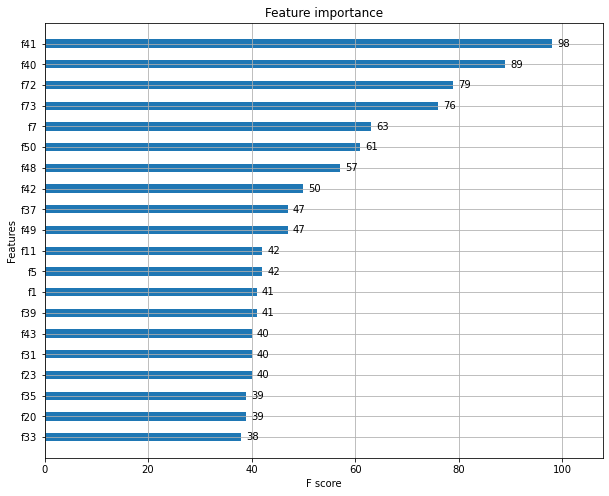

In [14]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=20, height=0.4)